In [13]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
from scipy.stats import linregress

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [14]:
def curve_to_fit(lsts, gain, offset):
    # Define curve to fit data to
    # offset is Tsys offset from zero = Trxr + g * <Tsky>
    global interp_values
    return (gain * interp_values + offset)


def match_model_to_data(pol, fi, params):
    # Take model (params correspond to fit parameters from curve_to_fit)
    # and create curve that should match the observed data (ie. apply gains to theory)
    global Tsky_prime
    interp_values = Tsky_prime[pol, fi, :]
    return (params[0] * interp_values + params[1])


def match_data_to_model(data, params, mean):
    # Use model (params correspond to fit parameters from curve_to_fit)
    # to correct the data to match the theoretical Tsky (ie. apply gains to data)
    return (data - params[1]) / params[0] + mean

In [15]:
JD = 2458116


# Tsky_file = '/data4/tcox/HERA_IDR1_analysis/HERA_Tsky.npz'
Tsky_file = '/Users/tyler/Desktop/Research/Tsys/data/HERA_Tsky_nic.npz'
data = np.load(Tsky_file)
freqs = data['freqs']  # These are already made to fit the data
model_lsts = data['lsts']
model_HERA_Tsky = data['HERA_Tsky']

data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
#gains_Jy = data['gains']
#rxr_temp = data['rxr_temp']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos.npz'.format(JD)
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']

pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)


bad_ants_xx = [0, 25, 67] # Visually inspected high receiver temperature in the xx
bad_ants_yy = [2, 11, 85] # Visually inspected high receiver temperature in the yy

bad_ants_xx_nrao = [143, 123, 122]
bad_ants_yy_nrao = [123, 120, 122]

bad_ants = [bad_ants_xx, bad_ants_yy]
bad_ants_nrao = [bad_ants_xx_nrao, bad_ants_yy_nrao]
# Fit auto data to model
auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
r_squared = np.zeros((npol, nant, len(freqs)))
m_err = np.zeros((npol, nant, len(freqs)))
covs = np.zeros((npol, nant, len(freqs), 2, 2))

# Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
interp_Tsky_array = interp_Tsky(data_lsts[0])
Tsky_mean = np.mean(interp_Tsky_array, axis=2)
Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)

In [16]:
for pol in xrange(npol):
    for fi, freq in enumerate(freqs):
        interp_values = Tsky_prime[pol, fi, :]
        for anti, ant in enumerate(HERA_list):
            m, b, r, p_val, stderr = linregress(interp_values,  data_ave[pol][ant, :, fi])
            m_err[pol, anti, fi] = stderr
            auto_fits[pol, anti, fi, :] = [m,b]
            r_squared[pol, anti, fi] = r**2

In [17]:
gains = auto_fits[:, :, :, 0]
rxr_temp = auto_fits[:, :, :, 1] / gains - Tsky_mean[:, None, :]

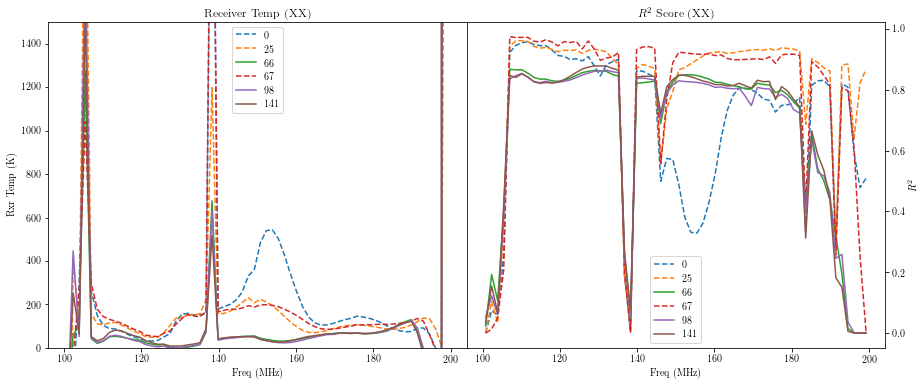

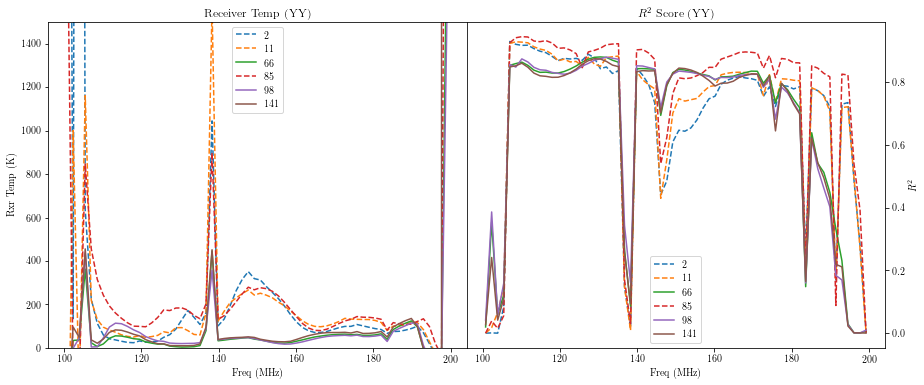

In [8]:
for pol in np.arange(npol):
    fig, axarr = plt.subplots(1, 2, figsize=(15, 6))
    for anti, ant in enumerate(HERA_list):
        if ant in bad_ants[pol]:
            axarr[0].plot(freqs, rxr_temp[pol, anti, :], label=str(ant), linestyle='--')
            axarr[1].plot(freqs, r_squared[pol, anti, :], label=str(ant), linestyle='--')
        elif ant in [98,66,141]:
            axarr[0].plot(freqs, rxr_temp[pol, anti, :], label=str(ant))
            axarr[1].plot(freqs, r_squared[pol, anti, :], label=str(ant))

    axarr[0].set_xlabel('Freq (MHz)')
    axarr[1].set_xlabel('Freq (MHz)')
    axarr[0].set_title('Receiver Temp (' + 2*pols[pol] + ')')
    axarr[1].set_title('$R^2$ Score (' + 2*pols[pol] + ')')
    axarr[0].set_ylim([0, 1500])
    #axarr[1].set_ylim([0, 1.05])
    axarr[0].legend()
    axarr[1].legend()
    axarr[0].set_ylabel('Rxr Temp (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylabel('$R^2$')
    #axarr[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(wspace=0.0)
    #plt.savefig('../IDR2/{JD}/receiver_temp_r2_{pol}_{JD}.png'.format(JD=JD, pol=2*pols[pol]), dpi = 300)

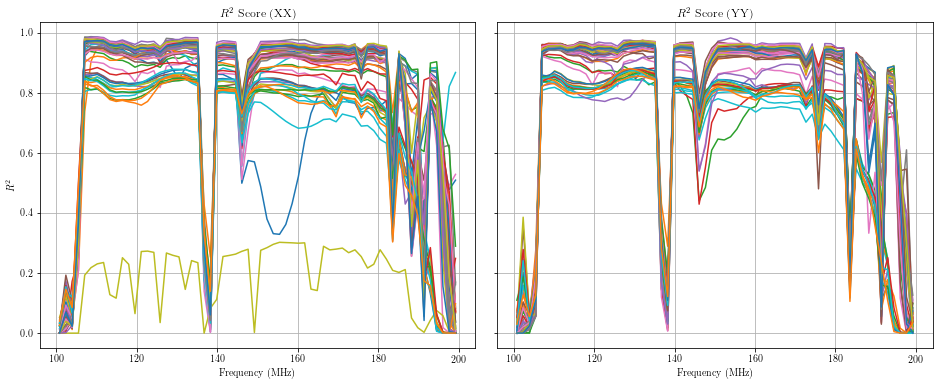

In [37]:
fig, axarr = plt.subplots(1, 2, sharey=True,figsize=(16, 6))

for pol in np.arange(npol):
    for anti, ant in enumerate(HERA_list):
        if ant in nrao_feeds:
            axarr[pol].plot(freqs, r_squared[pol, anti, :], label=str(ant))
        else:
            axarr[pol].plot(freqs, r_squared[pol, anti, :], label=str(ant))
    axarr[pol].set_xlabel('Frequency (MHz)')
    axarr[pol].set_title('$R^2$ Score (' + 2*pols[pol] + ')')
    axarr[0].set_ylabel('$R^2$')
    axarr[pol].grid()
    #axarr[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/receiver_temp_r2_{JD}.png'.format(JD=JD), dpi = 200, bbox_inches='tight')
    


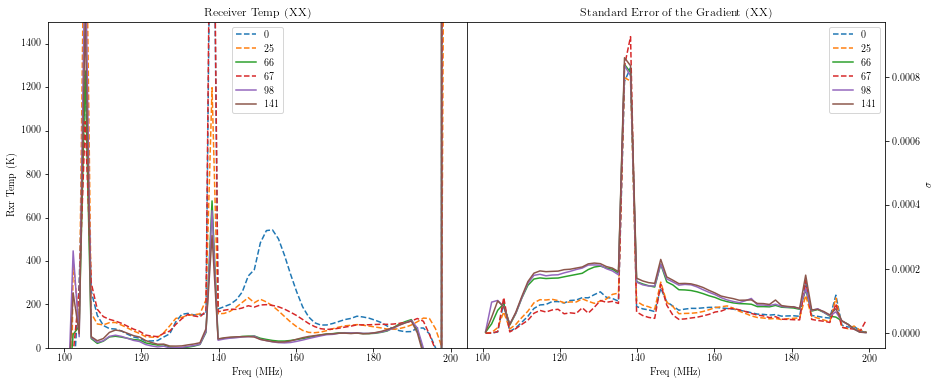

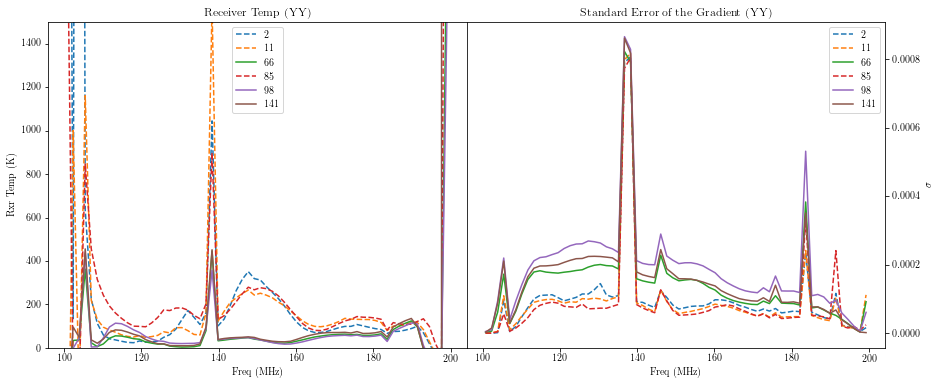

In [139]:
for pol in np.arange(npol):
    fig, axarr = plt.subplots(1, 2, figsize=(15, 6))
    for anti, ant in enumerate(HERA_list):
        if ant in bad_ants[pol]:
            axarr[0].plot(freqs, rxr_temp[pol, anti, :], label=str(ant), linestyle='--')
            axarr[1].plot(freqs, m_err[pol, anti, :], label=str(ant), linestyle='--')
        elif ant in [98,66,141]:
            axarr[0].plot(freqs, rxr_temp[pol, anti, :], label=str(ant))
            axarr[1].plot(freqs, m_err[pol, anti, :], label=str(ant))

    axarr[0].set_xlabel('Freq (MHz)')
    axarr[1].set_xlabel('Freq (MHz)')
    axarr[0].set_title('Receiver Temp (' + 2*pols[pol] + ')')
    axarr[1].set_title('Standard Error of the Gradient (' + 2*pols[pol] + ')')
    axarr[0].set_ylim([0, 1500])
    #axarr[1].set_ylim([0, 1.05])
    axarr[0].legend()
    axarr[1].legend()
    axarr[0].set_ylabel('Rxr Temp (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylabel('$\sigma$')
    #axarr[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(wspace=0.0)
    #plt.savefig('../IDR2/{JD}/receiver_temp_stderr_{pol}_{JD}.png'.format(JD = JD, pol = 2*pols[pol]), dpi = 300)

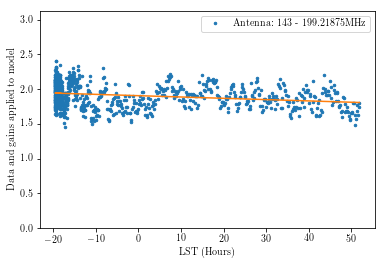

In [11]:
a,b = auto_fits[pol, anti, i, :]
label = 'Antenna: ' + str(ant) + ' - ' + str(freqs[i]) + 'MHz'
plt.plot(Tsky_prime[pol, i, :], data_ave[pol][ant, :, i], '.', ms=5, label=label)
plt.plot(Tsky_prime[pol, i, :], a*Tsky_prime[pol, i, :]+b)
plt.ylim([0, 1.3 * np.max(data_ave[pol][ant, :, i])])
plt.xlabel('LST (Hours)')
plt.ylabel('Data and gains applied to model')
plt.legend()
plt.show()